In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='serif')

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
df_train = pd.read_csv('/content/training_data.csv',header=None)
df_test = pd.read_csv('/content/testing_data.csv',header=None)

X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values

X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values


print(f'Our dataset has {df_train.shape[1]-1} features')

Our dataset has 4096 features


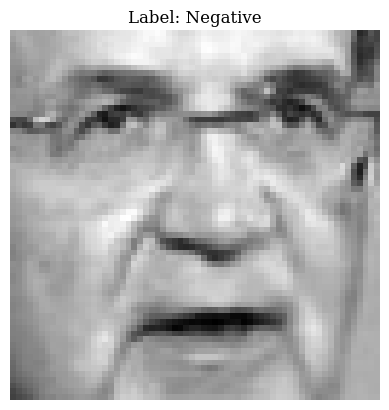

In [37]:
# Select a random image
n = np.random.randint(df_train.shape[0])
prueba = X_train[n].reshape((64,64))
plt.imshow(prueba,cmap='gray')
if y_train[n] == 1:
    target = 'Positive'
else:
    target = 'Negative'
plt.title(f"Label: {target}")
plt.axis('off')
plt.show()

In [6]:
from skimage.feature import hog

HOG feature vector with 1764 features


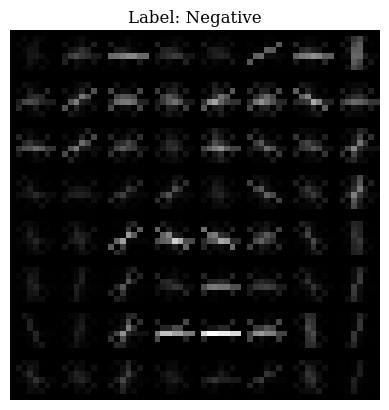

In [38]:
hog_feature_vector, hog_image = hog(prueba,
                                    orientations=9,
                                    pixels_per_cell=(8,8),
                                    cells_per_block=(2,2),
                                    visualize=True, # True if you want the HOG image, default value is False
                                      )
print(f"HOG feature vector with {len(hog_feature_vector)} features")
plt.imshow(hog_image,cmap='gray')
plt.axis('off')
plt.title(f"Label: {target}")
plt.show()

In [8]:
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [9]:
class DescriptorHOG(BaseEstimator, TransformerMixin):
    def __init__(self, hog_orientations = 9, hog_pixels_per_cell = (8,8), hog_cells_per_block=(2,2), hog_block_norm = 'L2', img_dim=(64,64)):
        self.hog_orientations = hog_orientations
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_block_norm = hog_block_norm
        self.img_dim = img_dim

    def fit(self, X, y=None):
        return self

    def feature_hog(self, arr):
        image = arr.reshape(self.img_dim)
        feature_vector = hog(image=image, orientations=self.hog_orientations,pixels_per_cell=self.hog_pixels_per_cell,
                            cells_per_block=self.hog_cells_per_block, block_norm=self.hog_block_norm)
        return feature_vector

    def transform(self, X):
        X_hog = np.apply_along_axis(func1d=self.feature_hog, axis=1, arr=X)
        return X_hog

In [10]:
# Feature Descriptor
#from OwnTransformers.ImageDescriptors import DescriptorHOG

#Imputer to replace NaNs with mean value of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

hog_descriptor = DescriptorHOG()
X_train_hog = hog_descriptor.transform(X=X_train_imputed)

#Debugging code
nan_mask = np.isnan(X_train_hog)
nan_count = np.sum(nan_mask)
print(f"Number of NaNs in X_train_hog: {nan_count}")



# Dimensionality reduction
porc_inf = 0.90
pca = PCA(n_components=porc_inf, svd_solver='full')
X_train_hog_reduced = pca.fit_transform(X_train_hog)

dim_sample_hog = X_train_hog.shape[1]
dim_sample_hog_reduced = X_train_hog_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample_hog} to {dim_sample_hog_reduced} features")
print(f"Aproximately {round(1- (dim_sample_hog_reduced/dim_sample_hog),3)*100}% of the number of its previous features")

Number of NaNs in X_train_hog: 0
Applying PCA (preserving 90.0% of information), the data set reduces from 1764 to 285 features
Aproximately 83.8% of the number of its previous features


In [11]:
from sklearn.svm import SVC

In [12]:
#from OwnTransformers.ImageDescriptors import DescriptorHOG
from sklearn.preprocessing import StandardScaler # Adding standardization --> all attributes are on the same scale
from sklearn.pipeline import Pipeline

In [26]:
gamma_01 = 0.001
C_01 = 10
model_01 = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=C_01, gamma=gamma_01))
    ])

In [27]:
#TRAINING
model_01.fit(X=X_train_imputed, y=y_train)

Pipeline(steps=[('hogdescriptor', DescriptorHOG()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('scaler', StandardScaler()), ('svm', SVC(C=10, gamma=0.001))])

In [28]:
#TESTING
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score

In [29]:
# Make predictions
y_predict_01 = model_01.predict(X=X_test_imputed)

# Create ROC Curve + ROC AUC score
y_scores_01 = model_01.decision_function(X_test_imputed)
fpr_01, tpr_01, _ = roc_curve(y_true=y_test, y_score=y_scores_01)
roc_auc_01 = roc_auc_score(y_true=y_test, y_score= y_scores_01)

In [30]:
# Create Confusion Matrix
confMatrix = pd.DataFrame( confusion_matrix(y_true=y_test, y_pred=y_predict_01),
                         index = ['Negative', 'Positive'],
                         columns = ['Negative', 'Positive']
                         )
confMatrix.index.name = 'Actual'
confMatrix.columns.name = 'Predicted'

In [31]:
# Print classificacion metrics
print(f'Accuracy of the model: {accuracy_score(y_test,y_predict_01)}')
print(f'Precision of the model: {precision_score(y_test,y_predict_01)}')
print(f'Recall of the model: {recall_score(y_test,y_predict_01)}')
print(f'F1-Score of the model: {f1_score(y_test,y_predict_01)}')

Accuracy of the model: 0.8797083839611178
Precision of the model: 0.7957351290684624
Recall of the model: 0.7681473456121344
F1-Score of the model: 0.7816979051819184


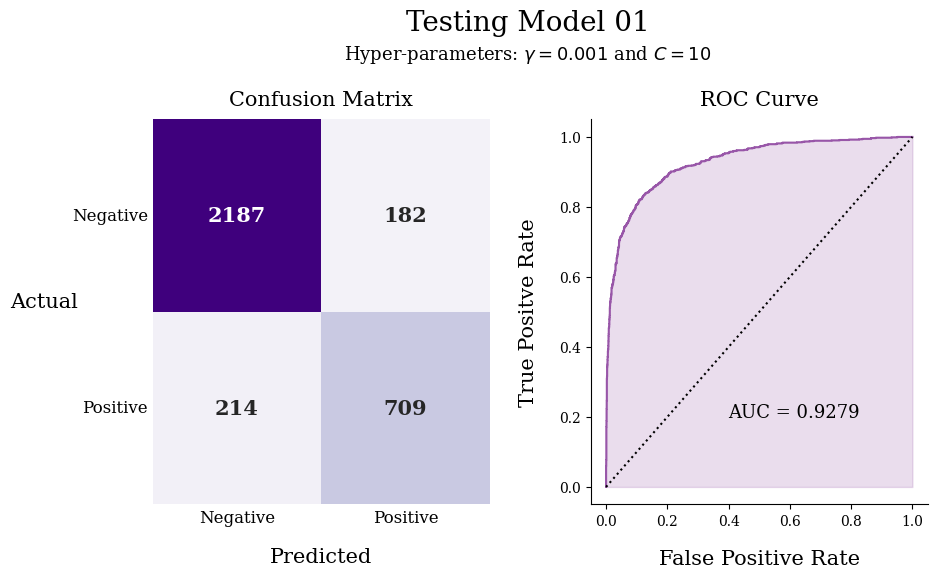

In [34]:
# Plot Confussion Matrix and ROC Curve
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)

# Heatmap
sns.heatmap(data=confMatrix, annot=True, fmt='d', square=False, cmap='Purples',vmin=0, cbar=False, ax=ax1,
annot_kws = {'size': 15, 'fontdict':{'fontweight':'bold'}}
)
# ROC Curve
ax2.plot(fpr_01, tpr_01, color='#9856A8')
ax2.fill_between(x=fpr_01, y1=tpr_01, color = '#9856A8', alpha=0.2)
ax2.text(x=0.4,y=0.2, s=f'AUC = {round(roc_auc_01,4)}', fontdict=dict(size=13))
# Randon classifier
ax2.plot([0,1],[0,1], linestyle='dotted', color='black')


fig.suptitle('Testing Model 01', size = 20,y=1.1)
fig.text(x=0.5,y=1, s=f'Hyper-parameters: $\gamma = {gamma_01}$ and $C = {C_01}$', ha='center', fontdict=dict(size=13))
ax1.set_title(f"Confusion Matrix", pad=10, size=15)
ax2.set_title('ROC Curve', pad=10, size=15)

ax1.set_ylabel('Actual',rotation=0, labelpad=20, size=15)
ax1.set_xlabel('Predicted', labelpad=15, size=15)
ax1.tick_params(axis='both', which='both', length=0)
ax1.tick_params(axis='y', rotation=0)
ax1.tick_params(labelsize=12)

ax2.set_xlabel('False Positive Rate', labelpad=15, size=15)
ax2.set_ylabel('True Positve Rate', labelpad=15, size=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)
subset_mask = np.isin(y, [1, 2])  # binary classification: 1 vs 2
X, y = X[subset_mask], y[subset_mask]

disp = ValidationCurveDisplay.from_estimator(
    SVC(),
    X,
    y,
    param_name="gamma",
    param_range=np.logspace(-6, -1, 5),
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
disp.ax_.set_title("Validation Curve for SVM with an RBF kernel")
disp.ax_.set_xlabel(r"gamma (inverse radius of the RBF kernel)")
disp.ax_.set_ylim(0.0, 1.1)
plt.show()

In [ ]:
#FINE TUNED MODEL
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
# Declare grid of hyper-parameters
dict_hyperparams = dict(svm__gamma=[0.001,0.01,0.1], svm__C = [1,10,100,1_000])

# Cross Validation for GridSearchCV
crossVal = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
model_02 = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
    ])

grid = GridSearchCV(
    estimator= model_02, # Model
    param_grid= dict_hyperparams, # hyper-parameters
    cv= crossVal, # Cross Validation
    n_jobs=-1, # Use all CPU's
    verbose= 5 # Info
)

In [ ]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed: 10.7min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed: 14.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('hogdescriptor',
                                        DescriptorHOG(hog_block_norm='L2',
                                                      hog_cells_per_block=(2,
                                                                           2),
                                                      hog_orientations=9,
                                                      hog_pixels_per_cell=(8,
                                                                           8),
                                                      img_dim=(64, 64))),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.9, random_state=None,
                                            svd_so

In [ ]:
# Best params
gamma_02 = grid.best_params_['svm__gamma']
C_02 = grid.best_params_['svm__C']

### Testing Model 02

In [ ]:
# Make predictions
y_predict_02 = grid.predict(X=X_test)

# Create ROC Curve + ROC AUC score
y_scores_02 = grid.decision_function(X_test)
fpr_02, tpr_02, _ = roc_curve(y_true=y_test, y_score=y_scores_02)
roc_auc_02 = roc_auc_score(y_true=y_test, y_score= y_scores_02)

In [ ]:
# Create Confussion Matrix
confMatrix_02 = pd.DataFrame( confusion_matrix(y_true=y_test, y_pred=y_predict_02),
                         index = ['Negative', 'Positive'],
                         columns = ['Negative', 'Positive']
                         )
confMatrix_02.index.name = 'Actual'
confMatrix_02.columns.name = 'Predicted'

In [ ]:
# Print classificacion metrics
print(f'Accuracy of the model: {accuracy_score(y_test,y_predict_02)}')
print(f'Precision of the model: {precision_score(y_test,y_predict_02)}')
print(f'Recall of the model: {recall_score(y_test,y_predict_02)}')
print(f'F1-Score of the model: {f1_score(y_test,y_predict_02)}')

Accuracy of the model: 0.9106925880923451
Precision of the model: 0.8661233993015134
Recall of the model: 0.8060671722643553
F1-Score of the model: 0.835016835016835


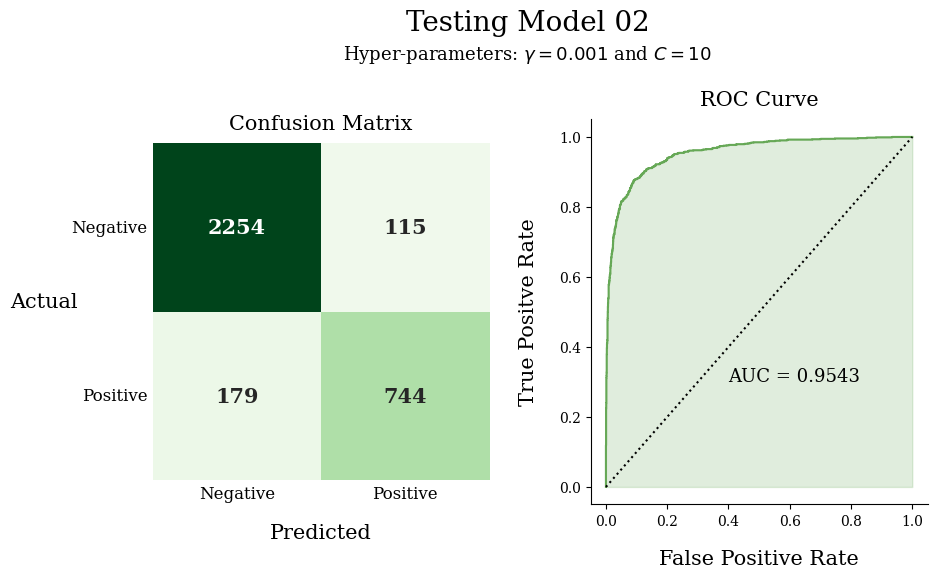

In [ ]:
# Plot Confussion Matrix and ROC Curve
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)

sns.heatmap(data=confMatrix_02, annot=True, fmt='d', square=True, cmap='Greens',vmin=0, cbar=False, ax=ax1,
annot_kws = {'size': 15, 'fontdict':{'fontweight':'bold'}}
)

ax2.plot(fpr_02, tpr_02, color='#66A856')
ax2.fill_between(x=fpr_02, y1=tpr_02, color = '#66A856', alpha=0.2)
ax2.text(x=0.4,y=0.3, s=f'AUC = {round(roc_auc_02,4)}', fontdict=dict(size=13))
ax2.plot([0,1],[0,1], linestyle='dotted', color='black')


fig.suptitle('Testing Model 02', size = 20,y=1.1)
fig.text(x=0.5,y=1, s=f'Hyper-parameters: $\gamma = {gamma_02}$ and $C = {C_02}$', ha='center', fontdict=dict(size=13))
ax1.set_title(f"Confusion Matrix", pad=10, size=15)
ax2.set_title('ROC Curve', pad=10, size=15)


ax1.set_ylabel('Actual',rotation=0, labelpad=20, size=15)
ax1.set_xlabel('Predicted', labelpad=15, size=15)
ax1.tick_params(axis='both', which='both', length=0)
ax1.tick_params(axis='y', rotation=0)
ax1.tick_params(labelsize=12)

ax2.set_xlabel('False Positive Rate', labelpad=15, size=15)
ax2.set_ylabel('True Positve Rate', labelpad=15, size=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.show()